Setting refAnt: RS407HBA
Loaded 8 antennas, 3595 times, 8 directions
Setting refAnt: RS407HBA
Setting refAnt: RS407HBA
Using radio array Radio Array: 1.50000e+08 MHz, Longitude 6.71 deg Latitude 52.93 deg Height -77.28 m
Using phase center 217.76998437499998 deg 34.85346701388889 deg
Fixing frame at 2014-08-10T16:59:59.988
Elevation is 71.76514541650072 deg
Sun at zenith angle 71.8823306927399
Creating ionosphere model...
Found domain u in -188.73104809306585..164.61955905626743, v in -218.97259974148363..206.32673224432386, w in -116.9676161631947..1119.8194279422687
Nx=71 Ny=86 Nz=248 number of cells: 1514288
Calculating rays...
Casting rays: 64
splitting over directions


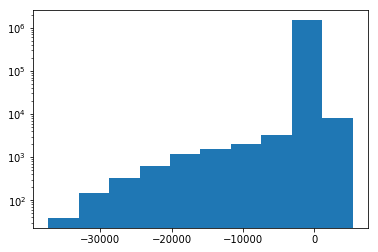

5e-06 869628.112105
2.5e-06 196920.104871
1.25e-06 44716.109124
6.25e-07 10111.3170593
3.125e-07 2655.01163265
1.5625e-07 1324.67742892
S0: 1569.0789125499887
Parabolic minimum: 1.0434135577434889e-07, 1236.4640670966478
misfit: 1.0434135577434889e-07, 1232.067798448914


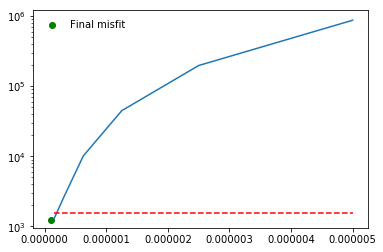

In [5]:
'''Do a line search to find minimum in gradient direction'''
import numpy as np

from ForwardEquation import forwardEquation, forwardEquation_dask
from TricubicInterpolation import TriCubic

def vertex(x1,x2,x3,y1,y2,y3):
    '''Given three pairs of (x,y) points return the vertex of the
         parabola passing through the points. Vectorized and common expression reduced.'''
    #Define a sequence of sub expressions to reduce redundant flops
    x0 = 1/x2
    x4 = x1 - x2
    x5 = 1/x4
    x6 = x1**2
    x7 = 1/x6
    x8 = x2**2
    x9 = -x7*x8 + 1
    x10 = x0*x1*x5*x9
    x11 = 1/x1
    x12 = x3**2
    x13 = x11*x12
    x14 = 1/(x0*x13 - x0*x3 - x11*x3 + 1)
    x15 = x14*y3
    x16 = x10*x15
    x17 = x0*x5
    x18 = -x13 + x3
    x19 = y2*(x1*x17 + x14*x18*x6*x9/(x4**2*x8))
    x20 = x2*x5
    x21 = x11*x20
    x22 = x14*(-x12*x7 + x18*x21)
    x23 = y1*(-x10*x22 - x21)
    x24 = x16/2 - x19/2 - x23/2
    x25 = -x17*x9 + x7
    x26 = x0*x1*x14*x18*x5
    x27 = 1/(-x15*x25 + y1*(x20*x7 - x22*x25 + x7) + y2*(-x17 + x25*x26))
    x28 = x24*x27
    return x28,x15 + x22*y1 + x24**2*x27 - x26*y2 + x28*(-x16 + x19 + x23)

def lineSearch(rays,K_ne,mTCI,i0,gradient,g,dobs,CdCt,figname=None):
    M = mTCI.getShapedArray()
    #g = forwardEquation_dask(rays,K_ne,mTCI,i0)
    dd = (g - dobs)**2/(CdCt + 1e-15)
    S0 = np.sum(dd)/2.
    ep_a = []
    S_a = []
    S = S0
    epsilon_n = 1e-5
    iter = 0
    while S >= S0 or iter < 5:
        epsilon_n /= 2.
        #mTCI.m = m - epsilon_n*gradient.ravel('C')
        g = forwardEquation_dask(rays,K_ne,TriCubic(mTCI.xvec,mTCI.yvec,mTCI.zvec,M - epsilon_n*gradient),i0)
        #print(np.mean(g),np.var(g))
        dd = (g - dobs)**2/(CdCt + 1e-15)
        S = np.sum(dd)/2.
        ep_a.append(epsilon_n)
        S_a.append(S)
        #print(epsilon_n,S)
        if not np.isnan(S):
            if S < 1<<64:
                iter += 1
    epsilon_n,S_p = vertex(*ep_a[-3:],*S_a[-3:])
    
    g = forwardEquation_dask(rays,K_ne,TriCubic(mTCI.xvec,mTCI.yvec,mTCI.zvec,M - epsilon_n*gradient),i0)
    dd = (g - dobs)**2/(CdCt + 1e-15)
    S = np.sum(dd)/2.
    print("S0: {}".format(S0))
    print("Parabolic minimum: {}, {}".format(epsilon_n,S_p))
    print("misfit: {}, {}".format(epsilon_n,S))
    if figname is not None:
        import pylab as plt
        plt.plot(ep_a,S_a)
        plt.scatter(epsilon_n,S,c='green',label='Final misfit')
        #plt.scatter(epsilon_n,S_p,c='red',label='Parabolic minimum')
        plt.yscale('log')
        plt.plot([np.min(ep_a),np.max(ep_a)],[S0,S0],ls='--',c='red')
        plt.legend(frameon=False)
        plt.savefig("{}.png".format(figname),format='png')
    return epsilon_n
    
def test_lineSearch():
    from RealData import DataPack
    from TricubicInterpolation import TriCubic
    from CalcRays import calcRays

    from InitialModel import createInitialModel
    from Gradient import computeGradient, computeGradient_dask
    i0 = 0
    datapack = DataPack(filename="output/test/datapackSim.hdf5").clone()
    antennas,antennaLabels = datapack.get_antennas(antIdx = -1)
    patches, patchNames = datapack.get_directions(dirIdx=-1)
    times,timestamps = datapack.get_times(timeIdx=[0])
    datapack.setReferenceAntenna(antennaLabels[i0])
    neTCI = createInitialModel(datapack,antIdx = -1, timeIdx = -1, dirIdx = -1, zmax = 1000.)
    dobs = datapack.get_dtec(antIdx = -1, timeIdx = [0], dirIdx = -1)
    CdCt = (0.15*np.abs(dobs))**2
    Na = len(antennas)
    Nt = len(times)
    Nd = len(patches)  
    fixtime = times[Nt>>1]
    phase = datapack.getCenterDirection()
    arrayCenter = datapack.radioArray.getCenter()
    print("Calculating rays...")
    rays = calcRays(antennas,patches,times, arrayCenter, fixtime, phase, neTCI, datapack.radioArray.frequency, True, 1000., 100)
    mTCI = neTCI.copy()
    K_ne = np.mean(mTCI.m)
    mTCI.m /= K_ne
    np.log(mTCI.m,out=mTCI.m)
    #print(neTCI.m)
    g = forwardEquation(rays,K_ne,mTCI,i0)
    #gradient = computeGradient(rays, g, dobs, 0, K_ne, mTCI, mTCI.getShapedArray(), CdCt, 1, 3, 5.)
    gradient = computeGradient_dask(rays, g, dobs,  i0, K_ne, mTCI, mTCI.getShapedArray(), CdCt, 1, 5, 5.)
    import pylab as plt
    plt.hist(gradient.flatten())
    plt.yscale('log')
    plt.show()
    lineSearch(rays,K_ne,mTCI,i0,gradient,g,dobs,CdCt,figname=None)
    
def test_vertex():
    x = np.linspace(0,1,100)
    y = (x-0.25)**2 + 2*(x-0.75)**2- 1
    idx = np.random.randint(100,size=3)
    x0,y0 = vertex(*x[idx],*y[idx])
    import pylab as plt
    plt.plot(x,y)
    plt.scatter(x[idx],y[idx],c='red')
    plt.scatter(x0,y0,c='green')
    plt.xlim([0,1])
    plt.show()
    
    
if __name__=='__main__':
    test_lineSearch()
    
    #test_vertex()
    
    